In [1]:
import numpy as np
import pandas as pd
import warnings

## Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

## Sklearn Libraries
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import *

# Define random state
random_state = 2018
np.random.seed(random_state)
warnings.filterwarnings('ignore')

In [2]:
x = pd.read_csv('./usa_blank_upd_.csv')
df = pd.DataFrame(x)
df.set_index('zip', inplace=True)

In [3]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
X = df[['Index Change', 'Percent_Change_House', 'Percent_Change_Rent', 'Percent_Change_Public_Transp',
      'Percent_Change_Population', 'Percent_Change_White']]


y = df['Gentrified']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, stratify=y)


In [6]:
# implement random oversampling
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

Counter(y_resampled)

Using TensorFlow backend.


Counter({0: 728, 1: 728})

In [7]:
print('y_resampled class distribution')
print(y_resampled.value_counts(normalize=True))
print('y_test class distribution')
print(y_test.value_counts(normalize=True))

y_resampled class distribution
1    0.5
0    0.5
Name: Gentrified, dtype: float64
y_test class distribution
0    0.89011
1    0.10989
Name: Gentrified, dtype: float64


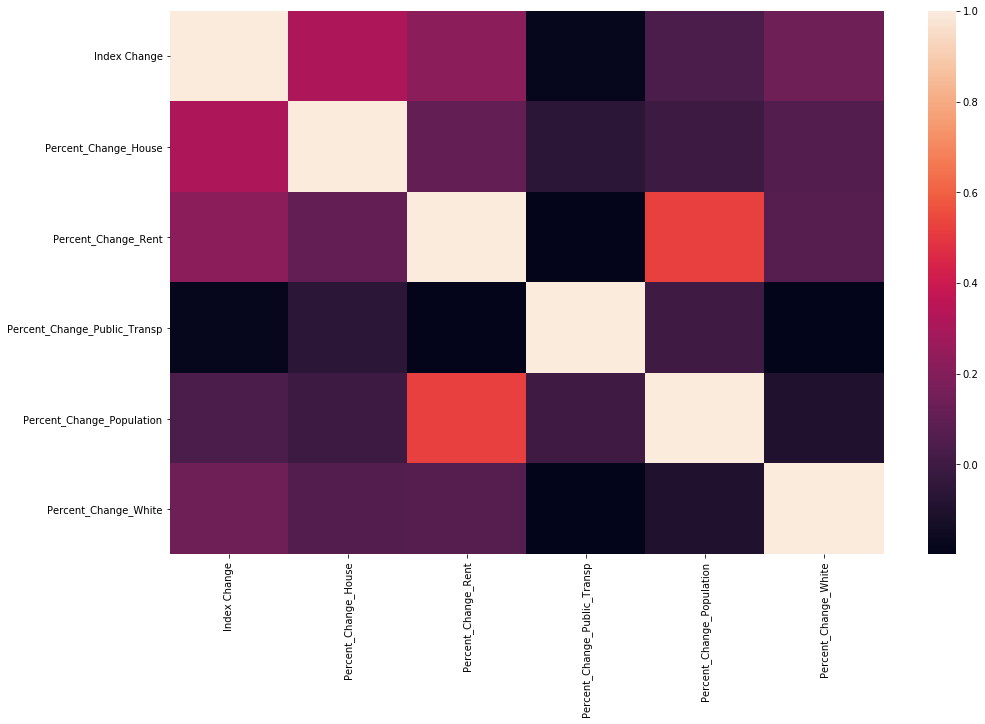

In [8]:
import seaborn as sns
cor = X.corr()
plt.figure(figsize=(16,10))
sns.heatmap(cor)
plt.show()

In [27]:

#from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 1)

clf = RandomForestClassifier(random_state = 1) 
scoring = {'Recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)
          }

params = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

grid_clf = GridSearchCV(estimator = clf, param_grid = params, cv = cv, n_jobs=-1, verbose=4)
grid_clf.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   15.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                             

In [28]:
print(grid_clf.best_estimator_)
print(grid_clf.best_params_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)
{'max_depth': 3, 'max_features': 3, 'min_samples_split': 3, 'n_estimators': 100}


In [56]:
from sklearn.utils.class_weight import compute_sample_weight

sample_weight = compute_sample_weight(class_weight='balanced', y=y)

In [29]:

clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [33]:
clf = clf.fit(X_resampled, y_resampled)


pred = clf.predict(X_test)

#accuracy = accuracy_score(y_test, predicted)


In [34]:
cm = confusion_matrix(y_test, pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df
acc = accuracy_score(y_test, pred)

In [35]:
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc}")
print("Classification Report")
print(classification_report(y_test, pred))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,221,22
Actual 1,24,6


Accuracy Score : 0.8315018315018315
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       243
           1       0.21      0.20      0.21        30

    accuracy                           0.83       273
   macro avg       0.56      0.55      0.56       273
weighted avg       0.83      0.83      0.83       273



In [32]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

AttributeError: 'NoneType' object has no attribute '_check_is_fitted'